# Peer evaluation form is here:

https://forms.gle/tKcZeVUKb8wx5zTJ8

## User notes:

This file is not a "complete" answer report. (Though I did all the "bonuses" except for the regression.)
- There is very little data description (EDA) and discussion of the sample. While I note a few things, I don't discuss what my observations mean for the subsequent analysis.
- My data description occurs before I've merged in returns, which is weird: It should happen after the returns are in, so I can discuss all the analysis variables!
- Plotting the average daily return throughout the sample would be good.
- Even better: plot separate lines of average daily return for the group of firms with "high" risk measures and the group with "low" risk measures
- My exploration of the risk measures is weak: Just the mean, max, etc plus the fraction that aren't zero. Seeing how they are related to the industry of the firm would be a good idea, as several students noted (and did)!
- I present all the correlations in a single visualization (neat!), but my short summary is too brief.
- Putting a summary section at the top of the document is something you'd expect in a report!


In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm     # progress bar on loops
from NEAR_regex import NEAR_regex  # copy this file into the asgn folder
from bs4 import BeautifulSoup
import re
from time import sleep
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import statsmodels.api as sm

#if tqdm issues, run this in terminal or with ! trick
#jupyter nbextension enable --py widgetsnbextension
#jupyter labextension install @jupyter-widgets/jupyterlab-manager



## The sample

1. S&P 500 firms (N=505) are obtained from wikipedia (see `DL_10ks.ipynb`)
2. Several new measures based on searches of the text of the firms' wiki pages are created for N=504 firms (see `measure_risks.ipynb`). Note that Pool Corp has no wiki page. 
3. N=362 of those firms are in the CCM data provided
4. Several CCM variables are _not_ defined for all 362 firms: The tax loss carry forward variables have N=279, short debt = 354, INVOPPS = 357, and sales growth has N = 0. 

In [2]:
# load
sp500 = pd.read_csv('output/sp500_accting_plus_textrisks.csv')

# summary stats
(
    sp500.describe().T
    # these are identifiers, industry classifications, 
    # or large numbers (market equity "me" and total debt "td")
    # that mess up formatting/readability
    .drop(['gvkey','lpermno','CIK','sic','me','td'])
    .style.format('{:,.1f}')
)    

,count,mean,std,min,25%,50%,75%,max
tax_risks,504.0,0.0,0.1,0.0,0.0,0.0,0.0,1.0
tariff_risk,504.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fincon,504.0,0.2,0.6,0.0,0.0,0.0,0.0,6.0
proprietary,504.0,0.0,0.1,0.0,0.0,0.0,0.0,1.0
fyear,362.0,"2,018.9",0.3,"2,018.0","2,019.0","2,019.0","2,019.0","2,019.0"
sic3,362.0,426.2,191.0,10.0,284.0,373.5,533.0,874.0
long_debt_dum,362.0,1.0,0.1,0.0,1.0,1.0,1.0,1.0
l_a,362.0,9.7,1.2,6.6,8.8,9.7,10.6,13.2
l_sale,362.0,9.3,1.2,6.4,8.5,9.2,10.0,13.1
div_d,362.0,0.8,0.4,0.0,1.0,1.0,1.0,1.0


## The new measures

These searches were defined with a slightly different project in mind, but the general ideas of _**how**_ and _**why**_ these are set up as they are applies:

### Tax risk exposure

Technology firms are often involved in large amounts of creative accounting to reduce tax bills. To identify when a firm is negatively exposed to possible tax changes, I look for a firm mentioning a "risk term" near "tax" (or similar) and "changes". 

**HIT:** "A change to tax policies could negatively affect profits"

**NOT A HIT:** "A change to tax policies is likely"

In [3]:
# this will look for mentions with 25 word gaps maximum
tax_risks = ['(risk|risks|could harm|negative|negatively|uncertain)',
            '(tax|taxes|taxation)',
            '(change|new|law|policy|policies|regulation|regulations)']

### Tariffs

Technology firms often ship product across international borders. To identify when a firm is negatively exposed to possible tariff changes, I look for a firm mentioning a "risk term" near "tariff" (or similar) and "changes". 

**HIT:** "A change to tariff policies could negatively affect profits"

**NOT A HIT:** "A change to tariff policies is likely"

In [4]:
# this will look for mentions with 25 word gaps maximum
tariff_search = ['(risk|risks|could harm|negative|negatively)',
                '(tariff|tariffs)',
                '(change|new|law|policy|policies|regulation|regulations)']

### Financial constraints

Technology firms tend to be younger and smaller than other public firms. According to published research, young and small firms also tend to be financially constrained.

Following [Hoberg and Maksimovic](https://poseidon01.ssrn.com/delivery.php?ID=875082005085007108066003027097109092018052053087053016092066101124083072025114105026038106063111031098097099020098001110068066029018023080043026109080070118114124088008042110092095070091123122124087109120115122022004003119096075106076087081087092093&EXT=pdf), I define firms as financially constrained if a firm discusses "curtailing" near "investment". The full lists, below, come from the paper.

In [5]:
# this list comes from page 9 of the WP version of Hoberg and Maksimovic (link above)

# allow for partial matches and a max gap of 25 (they use 12, but our text is messier)
fin_constraints = ['(delay|abandon|eliminate|curtail|scale back|postpone)',
                   '(construction|expansion|acquisition|restructuring|project|research|development|exploration|product|expenditure|manufactur|entry|renovat|growth|activities|capital improvement|capital spend|capital proj|commercial release|business plan|transmitter deployment|opening restaurants)' ]

### Proprietary Information Leak Risk

A crucial task for technology firms is protecting their IP. Following [Hoberg and Maksimovic](https://poseidon01.ssrn.com/delivery.php?ID=875082005085007108066003027097109092018052053087053016092066101124083072025114105026038106063111031098097099020098001110068066029018023080043026109080070118114124088008042110092095070091123122124087109120115122022004003119096075106076087081087092093&EXT=pdf) again, I define firms worried about IP leaks as those that discuss "protecting" near "trade secrets" or "proprietary information". I could use a larger list, but this definition has been vetted.


In [6]:
proprietary_information_risks = ['(protect|safeguard)',
                                '(trade secret|proprietary information|confidential information)']

## Examining my proposed measures

Initial findings: 

1. The tariff risks search is ill defined for wikipedia pages - **it is always zero.** I'd have to simplify it, probably to a mere discussion of "tariffs", and adding a few related terms would probably help.
2. The proprietary and tax searches also seem to be poorly defined. Only EBAY, Oracle, Amazon, and Exxon show up when you run this, despite the S&P 500 containing many firms that rely on patents and that use aggressive tax management policies:

    ```python
    sp500.query('(proprietary != 0) | (tax_risks != 0)')
    ```
    
3. 14% (see below) of S&P500 firms have indicators for financial constraints. This is probably not "too high" (S&P500 firms should have pretty diverse funding options) or "too low" (arguably some of these firms should have a degree of constraint), but additional checks are warranted.      E.g. literally reading some webpages. 

In [7]:
# count the non-zero elements
(sp500[['tax_risks','tariff_risk','fincon','proprietary']] > 0).sum() / len(sp500)

tax_risks      0.003960
tariff_risk    0.000000
fincon         0.140594
proprietary    0.003960
dtype: float64

In [8]:
sp500[['tax_risks','tariff_risk','fincon','proprietary']].describe().T.style.format('{:,.2f}')

,count,mean,std,min,25%,50%,75%,max
tax_risks,504.00,0.00,0.06,0.00,0.00,0.00,0.00,1.00
tariff_risk,504.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
fincon,504.00,0.19,0.56,0.00,0.00,0.00,0.00,6.00
proprietary,504.00,0.00,0.06,0.00,0.00,0.00,0.00,1.00


## Correlation between firm variables and stock returns around covid

The coding plan: 
1. For each firm, create 3 return measures:
    1. Cumulative returns for Mar 9-Mar 13 ("acute onset" period)
    1. Cumulative returns for Feb 23-Mar 23 ("collapse" period)
    1. Returns on Mar 24 ("stimulus day")
1. Those returns do not control for systematic risk exposures (e.g. the CAPM model would control for returns expected due to covariation with market returns.) As a bonus, let's compute an alpha measure for each firm on each of those 3 periods.
    
    1. Compute $\beta_i$ for each firm $i$ in 2019.
    2. Compute $\alpha_{i,t}=return_{i,t}-\beta_i * MktRet_t$ using the $\beta_i$ we just computed, firm $i$'s cumulative return for Mar 9-Mar 13, and the cumulative market return for the same period
    3. Repeat step 2 for the other two periods.
    
1. Do a heatmap between the NON-risk adjusted cumulative returns, our text-based measures, and a few firm characteristics. 

### Load the returns data 

In [9]:
url = 'https://github.com/LeDataSciFi/ledatascifi-2021/blob/main/data/2019-2020-stock_rets%20cleaned.zip?raw=true'

#firms = pd.read_stata(url)   <-- would work, but GH said "too big" and forced me to zip it, 
# so here is the work around to download it:

with urlopen(url) as request:
    data = BytesIO(request.read())

with ZipFile(data) as archive:
    with archive.open(archive.namelist()[0]) as stata:
        returns = pd.read_stata(stata)
        
# convert to a date format
returns['date']=pd.to_datetime(returns.date,format="%Y%m%d")

# the returns variable has non-numeric stuff in it. 
returns['ret'] = pd.to_numeric(returns['ret'], errors='coerce') # coerce means any non-number becomes missingt

returns = returns.rename(columns={'ticker':'Symbol'})

### Compute alpha (aka risk factor adjusted returns) (BONUS)

1. Compute factor loadings in 2019, which gives you $\beta(Mkt)_i, \beta(SMB)_i, \beta(HML)_i$ for each firm i. That is, for each firm, there are betas with respect to three factors. [I'm adapting the code I posted here.](https://ledatascifi.github.io/ledatascifi-2021/content/estimate_factor_loadings.html?highlight=canonical)
2. In 2020, for compute alpha firm i on day t as $\alpha_{i,t} = ret_{i,t} - [\beta(Mkt)_i * MKT_t  + \beta(SMB)_i * SMB_t +  \beta(HML)_i * HML_t]$

In [10]:
def reg_in_groupby(df,formula="ret_excess ~ mkt_excess + SMB + HML"):
    '''
    Usage: 
        df.groupby(<whatever>).apply(reg_in_groupby)
        df.groupby(<whatever>).apply(reg_in_groupby,formula=<whatever>)
    '''
    return pd.Series(sm.formula.ols(formula,data = df).fit().params)

In [11]:
# download the FF data with factor returns
ff = (    
        pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3_daily',start=2018,end=2021)[0] 
        .reset_index()
        .rename(columns={"Mkt-RF":"mkt_excess", "Date":"date"})
        .set_index('date')/100  # convert FF daily percentage point values to # 
      )

So let's do the first step and compute the factor loadings:

In [12]:
factor_loadings =    (
                        ff
                        # merge into our firm-day returns
                        .merge(returns,right_on = 'date', left_index = True,how='inner',validate='one_to_many')

                        # Two things before the regressions:
                        # 1. need a year variable (to group on)
                        # 2. the market returns in FF are excess returns, so 
                        #    our stock returns need to be excess as well
                        .assign(ret_excess = lambda x: x.ret - x.RF,
                                year       = lambda x: x.date.dt.year)

                        # ok, run the regs, so easy!     (ONE TRICK IS NEEDED)
                        .dropna() # <--- some rows have missing ret, this fixed it
                        .groupby(['Symbol','year']).apply(reg_in_groupby) # if you groupby

                        # and clean up - with better var names
                        .rename(columns={'Intercept':'alpha',
                                        'mkt_excess':'beta_mkt',
                                        'SMB':'beta_SMB',
                                        'HML':'beta_HML'})
                        .reset_index()        
    
                        # we are looking at a 2020 event in the analysis, so keep the factors that were
                        # estimated BEFORE the event (not from same period, and def not later dates) 
                        .query('year == 2019') 
    
                    )

### Q: why did I do this last step? 

**A: Because 2019 asset pricing factors can be used in 2020, but not 2019!!!**

(...And 2020 asset pricing factors can be used in 2021, but not 2020!!!...)
   
The 2020 computations include data from Apr 2020, so we can't use it on events in March 2020, unless you have a time machine.
                       
**p.s. If you have a time machine, please get in touch. <3**


### Final step to compute (DAILY) risk adjusted returns 

$\alpha = y - \beta * X$. So, now, let's compute the daily alphas using our betas, and add them to our return data

In [13]:
returns = (
            # only grab factor returns from 2020 to ensure we don't apply the 2019 factors to earlier years
            # **these are the "X" in the regression formula**
            ff.reset_index().assign(year = lambda x: x.date.dt.year).query('year == 2020')

            # merge into our firm-day returns (RIGHT) and bring in the factors (LEFT)
            # **this are the y in the regression formula**
            .merge(returns,on='date',how='right',validate='one_to_many')
    
            # **these are the "B" in the regression formula**
            .merge(factor_loadings, on='Symbol',how='left')

            # compute alpha = y - B*X
            .assign(ret_excess = lambda x: x.ret - x.RF,
                    alpha = lambda x: x.ret_excess - (x.beta_mkt*x.mkt_excess + x.beta_SMB*x.SMB + x.beta_HML*x.HML))
    
            [['Symbol','date','alpha','ret']]
        ) 

### Add cumulative returns for each firm from Mar 9 - Mar 13 to analysis dataset

I'll add both the cumulative raw returns and the cumulative risk-adjusted returns (i.e. alphas).

_**Just drop the alpha line if you didn't compute alphas.**_

In [14]:
low, hi = datetime.datetime(2020,3,9), datetime.datetime(2020,3,13)

sp500 = (
        # create a dataframe with the returns cumulated for those dates
            (
                returns
                .query('(date >= @low) & (date <= @hi)')    # only cumulate for these dates
                 .assign(ret = lambda x: x.ret + 1,
                        alpha = lambda x: x.alpha + 1)      # gross returns, gross alphas
                 .groupby('Symbol').prod()-1                # cumulative prod, then subtract 1 
             # letting the parenthesis close here is necessary, 
             # else "to_frame" would try to work on "1" in prior line
             )
            .rename(columns=lambda x: x+'_0309_0313')
    
        # add to existing data
        .merge(sp500,how='right',on='Symbol')    
        )

### Add cumulative returns for each firm from Feb 23 - Mar 23 to analysis dataset

I'll add both the cumulative raw returns and the cumulative risk-adjusted returns (i.e. alphas).

In [15]:
low, hi = datetime.datetime(2020,2,23), datetime.datetime(2020,3,23)

sp500 = (
        # create a dataframe with the returns cumulated for those dates
            (
                returns
                .query('(date >= @low) & (date <= @hi)')    # only cumulate for these dates
                 .assign(ret = lambda x: x.ret + 1,
                        alpha = lambda x: x.alpha + 1)      # gross returns, gross alphas
                 .groupby('Symbol').prod()-1                # cumulative prod, then subtract 1 
             # letting the parenthesis close here is necessary, 
             # else "to_frame" would try to work on "1" in prior line
             )
            .rename(columns=lambda x: x+'_0223_0323')
    
        # add to existing data
        .merge(sp500,how='right',on='Symbol')    
        )

### Add returns on Mar 24 to analysis dataset

I'll add both the cumulative raw returns and the cumulative risk-adjusted returns (i.e. alphas).

In [16]:
stimmyday = datetime.datetime(2020,3,24)

sp500 = (
            returns
            .query('(date == @stimmyday)')      # only need return on this date, no cumulating
            .drop(columns='date')
            .set_index('Symbol')
            .rename(columns=lambda x: x+'_0324')
            .merge(sp500,how='right',on='Symbol')  # merge it in
        )

## Results

1. Firms with more financial flexibility (as measured by lower leverage (td_a), higher cash (cash_a), and higher profitability (prof_a)) did better during the collapse period (2/23-3/23) and the "acute onset" week of 3/9-3/13 (when the NBA season was halted). 
1. Those results, naturally, reverse on the stimulus day. In fact, all correlations flip signs when going from the collapse or acute onset periods to the stimulus day.
1. The patterns with alpha are the same. Because the patterns for raw returns and alpha returns are the same, this means that market, size, and value factors are not materially correlated with idiosyncratic returns of a firm over this time period and the firm's financial characteristics.
1. Of the text-based measures, only the financial constraints seemed potentially viable based on earlier examination. Firms with non-zero levels of this risk measure did better on the stimulus day and worse in the onset week (the reversal is expected), but _also_ might have done better during the longer "colllapse period". More investigation is needed. 

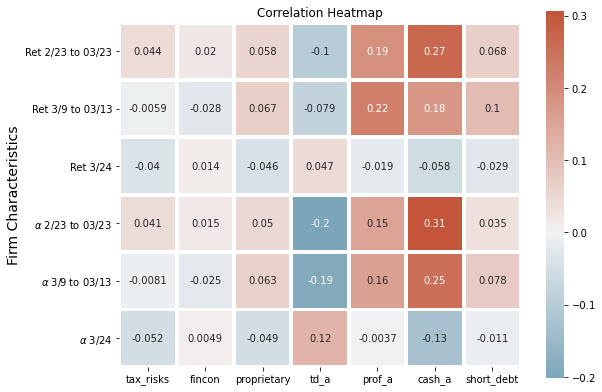

In [17]:
# dont plot identifying type info or categorical vars
corr = sp500[['ret_0223_0323', 'ret_0309_0313','ret_0324',
              'alpha_0223_0323', 'alpha_0309_0313','alpha_0324',
             'tax_risks', 'fincon', 'proprietary','td_a','prof_a','cash_a','short_debt']]\
        .corr().iloc[6:,:6]\

fig, ax = plt.subplots(figsize=(9,9)) # make a big space for the figure
sns.heatmap(corr.T ,
                 # cmap for the colors, 
                 center=0,square=True,
                 cmap=sns.diverging_palette(230, 20, as_cmap=True),
                 cbar_kws={"shrink": .75},
                 annot = True, # numbers in cells
                 linewidths = 3, # space between cells
                )

# FORMATTING CHOICES
plt.yticks(rotation=0) # rotate the labels on y-axis horizontal
# ax.xaxis.tick_top()    # put axis labels up top
ax.set_yticklabels([r'Ret 2/23 to 03/23',
                    r'Ret 3/9 to 03/13',
                    r'Ret 3/24',
                    r'$\alpha$ 2/23 to 03/23',
                    r'$\alpha$ 3/9 to 03/13',
                    r'$\alpha$ 3/24'])
ax.set_title(r"Correlation Heatmap")     
plt.ylabel(r'Returns (Raw and FF3 adjusted $\alpha$)', fontsize = 14)
plt.ylabel(r'Firm Characteristics', fontsize = 14)
plt.show()